# Modelo para Beta Bank.
---
Los clientes de Beta Bank se están yendo, cada mes, poco a poco, por lo que la empresa Beta Bank necesita un modelo que pueda predecir si un cliente dejará el banco pronto. 

Con los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco vamos a desarrollar un modelo que nos de el máximo valor F1 posible. Tenemos como objetivo un valor F1 de al menos 0.59.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

## Preparacion de datos y caracteristicas.

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Filtracion de columnas.
---
Tenemos diferentes columnas que en mi opinion no aportan informacion relavante que ayude al modelo a predecir si un cliente dejara el banco proximamente.

In [5]:
trash = ['RowNumber', 'CustomerId', 'Surname']

df = df.drop(trash, axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Tenemos datos nulos en la columna 'Tenure', vamos a sustituirlos por 'ND'. Mas adelante este valor sera codificado con One-Hot.

In [6]:
median = df['Tenure'].median()
print(median)

5.0


In [7]:
df[df['Tenure'].isnull()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [8]:
df['Tenure'].fillna(median, inplace=True)

### Transformación de características categóricas en numéricas.

In [9]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Separación de características y objetivo.

In [10]:
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

### Escalado y estandarización de características.

In [11]:
numeric = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age', 'NumOfProducts', 'Tenure']
for col in features[numeric]:
    minimo = features[col].min()
    maximo = features[col].max()
    print(f"Columna: {col}, minimo: {minimo}, maximo: {maximo}")

Columna: CreditScore, minimo: 350, maximo: 850
Columna: Balance, minimo: 0.0, maximo: 250898.09
Columna: EstimatedSalary, minimo: 11.58, maximo: 199992.48
Columna: Age, minimo: 18, maximo: 92
Columna: NumOfProducts, minimo: 1, maximo: 4
Columna: Tenure, minimo: 0.0, maximo: 10.0


In [12]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features[numeric])

features[numeric] = scaler.transform(features[numeric])

In [13]:
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.086246,-1.225848,-0.911583,1,1,0.021886,0,0,0
1,-0.440036,0.198164,-1.448581,0.117350,-0.911583,0,1,0.216534,0,1,0
2,-1.536794,0.293517,1.087768,1.333053,2.527057,1,0,0.240687,0,0,0
3,0.501521,0.007457,-1.448581,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,0.388871,-1.086246,0.785728,-0.911583,1,1,-0.365276,0,1,0


### Creacion de datasets para entrenamiento, validacion y prueba.

In [14]:
# Datos de entrenamiento.

features_train, sub_features, target_train, sub_target = train_test_split(
    features, target, test_size=0.40, random_state=12345)

print(features_train.shape)
print(sub_features.shape)

(6000, 11)
(4000, 11)


In [15]:
# Datos de validacion y prueba.

features_val, features_test, target_val, target_test = train_test_split(
    sub_features, sub_target, test_size=0.50, random_state=12345)

print(features_val.shape)
print(features_test.shape)

(2000, 11)
(2000, 11)


## Desequilibrio de clases.
---
A continuacion vamos a examinar que tan equilibradas se encuentran las clases, para despues entrenar un modelo sin tener en cuenta lo anterior y ver su rendimiento. 

In [16]:
print(target_train.value_counts(normalize=True))
print(target_train.value_counts())

0    0.800667
1    0.199333
Name: Exited, dtype: float64
0    4804
1    1196
Name: Exited, dtype: int64


Podemos ver que las clases en efecto se encuentran desbalanceadas, vamos a entrenar distintos modelos y calcularemos su calidad con diferentes metricas. 

### Decision Tree Classifier con clases desbalanceadas. 

In [17]:
%%time

for depth in range(1,9):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    
    predictions_val = model.predict(features_val)
    predictions_test = model.predict(features_test)
    
    accuracy_val = accuracy_score(target_val, predictions_val)
    f1_val = f1_score(target_val, predictions_val)
    
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_test = f1_score(target_test, predictions_test)
    
    print(f'max_depth={depth}, accuracy_valid={accuracy_val}, f1_valid={f1_val}, accuracy_test={accuracy_test}, f1_test={f1_test}')

max_depth=1, accuracy_valid=0.791, f1_valid=0.0, accuracy_test=0.7885, f1_test=0.0
max_depth=2, accuracy_valid=0.824, f1_valid=0.5217391304347825, accuracy_test=0.817, f1_test=0.4986301369863014
max_depth=3, accuracy_valid=0.838, f1_valid=0.4234875444839857, accuracy_test=0.83, f1_test=0.3795620437956204
max_depth=4, accuracy_valid=0.852, f1_valid=0.5528700906344411, accuracy_test=0.832, f1_test=0.48307692307692307
max_depth=5, accuracy_valid=0.853, f1_valid=0.5406249999999999, accuracy_test=0.842, f1_test=0.5015772870662459
max_depth=6, accuracy_valid=0.858, f1_valid=0.5696969696969697, accuracy_test=0.8485, f1_test=0.5359877488514548
max_depth=7, accuracy_valid=0.8505, f1_valid=0.5320813771517998, accuracy_test=0.8375, f1_test=0.4976816074188563
max_depth=8, accuracy_valid=0.85, f1_valid=0.5454545454545454, accuracy_test=0.833, f1_test=0.48773006134969327
CPU times: user 207 ms, sys: 11.9 ms, total: 219 ms
Wall time: 250 ms


Nuestro objetivo es alcanzar un valor F1 de al menos 0.59 para el dataset de prueba, estuvimos cerca, sigamos intentanto con diferentes algoritmos.

### Random Forest Classifier con clases desbalanceadas. 

In [18]:
%%time

for est in range(10, 100, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    
    predictions_val = model.predict(features_val)
    predictions_test = model.predict(features_test)
    
    accuracy_val = accuracy_score(target_val, predictions_val)
    f1_val = f1_score(target_val, predictions_val)
    
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_test = f1_score(target_test, predictions_test)
    
    print(f'estimators={est}, accuracy_valid={accuracy_val}, f1_valid={f1_val}, accuracy_test={accuracy_test}, f1_test={f1_test}')

estimators=10, accuracy_valid=0.85, f1_valid=0.5508982035928144, accuracy_test=0.84, f1_test=0.5046439628482972
estimators=20, accuracy_valid=0.849, f1_valid=0.5451807228915662, accuracy_test=0.844, f1_test=0.5258358662613981
estimators=30, accuracy_valid=0.856, f1_valid=0.5688622754491017, accuracy_test=0.846, f1_test=0.536144578313253
estimators=40, accuracy_valid=0.8545, f1_valid=0.5597579425113465, accuracy_test=0.844, f1_test=0.5258358662613981
estimators=50, accuracy_valid=0.857, f1_valid=0.5718562874251497, accuracy_test=0.8445, f1_test=0.5337331334332834
estimators=60, accuracy_valid=0.8575, f1_valid=0.5739910313901345, accuracy_test=0.845, f1_test=0.5345345345345346
estimators=70, accuracy_valid=0.8605, f1_valid=0.5817091454272864, accuracy_test=0.8465, f1_test=0.5369532428355959
estimators=80, accuracy_valid=0.859, f1_valid=0.575301204819277, accuracy_test=0.849, f1_test=0.5438066465256798
estimators=90, accuracy_valid=0.8585, f1_valid=0.5769805680119582, accuracy_test=0.8515

Vaya, nuestras metricas bajaron. No logramos nuestro objetivo con este modelo, intentemos con la regresion logistica. 

### Logistic Regression con clases desbalanceadas. 

In [19]:
%%time

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

predictions_val = model.predict(features_val)
predictions_test = model.predict(features_test)
    
accuracy_val = accuracy_score(target_val, predictions_val)
f1_val = f1_score(target_val, predictions_val)
    
accuracy_test = accuracy_score(target_test, predictions_test)
f1_test = f1_score(target_test, predictions_test)
    
print(f'accuracy_valid={accuracy_val}, f1_valid={f1_val}, accuracy_test={accuracy_test}, f1_test={f1_test}')

accuracy_valid=0.802, f1_valid=0.33108108108108103, accuracy_test=0.7915, f1_test=0.27478260869565213
CPU times: user 31.6 ms, sys: 40.3 ms, total: 71.9 ms
Wall time: 50.9 ms


Usando este modelo nuestras metricas cayeron aun mas. En lo personal me sorprendio el modelo de arbol de decisión. Ahora toca balancear las clases y ver los resultados.  

## Equilibrio de clases. 
---
A continuacion vamos a balancear las clases con la meta de aumentar nuestro valor de F1. Usaremos el modelo de arbol de decision, ya que con este estuvimos muy cerca de alcanzar la meta. 

### Ajuste de peso de clase.

In [20]:
%%time

for depth in range(1,9):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    
    predictions_val = model.predict(features_val)
    predictions_test = model.predict(features_test)
    
    accuracy_val = accuracy_score(target_val, predictions_val)
    f1_val = f1_score(target_val, predictions_val)
    
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_test = f1_score(target_test, predictions_test)
    
    print(f'max_depth={depth}, accuracy_valid={accuracy_val}, f1_valid={f1_val}, accuracy_test={accuracy_test}, f1_test={f1_test}')

max_depth=1, accuracy_valid=0.7545, f1_valid=0.4994903160040775, accuracy_test=0.74, f1_test=0.48514851485148514
max_depth=2, accuracy_valid=0.765, f1_valid=0.541015625, accuracy_test=0.7465, f1_test=0.5129682997118156
max_depth=3, accuracy_valid=0.765, f1_valid=0.541015625, accuracy_test=0.7465, f1_test=0.5129682997118156
max_depth=4, accuracy_valid=0.711, f1_valid=0.5277777777777778, accuracy_test=0.7155, f1_test=0.5385239253852393
max_depth=5, accuracy_valid=0.8105, f1_valid=0.5963791267305644, accuracy_test=0.798, f1_test=0.5809128630705395
max_depth=6, accuracy_valid=0.7665, f1_valid=0.5581835383159887, accuracy_test=0.762, f1_test=0.5656934306569343
max_depth=7, accuracy_valid=0.7725, f1_valid=0.5508390918065154, accuracy_test=0.77, f1_test=0.5593869731800767
max_depth=8, accuracy_valid=0.763, f1_valid=0.5398058252427185, accuracy_test=0.7575, f1_test=0.5479962721342032
CPU times: user 240 ms, sys: 48.1 ms, total: 288 ms
Wall time: 308 ms


Al ajustar el peso de ambas clases obtuvimos un valor de F1 de 0.59 para el dataset de validacion, pero nuestra meta es conseguirlo tambien en dataset de prueba. Sigamos ahora con sobremuestreo y submuestreo.

### Sobremuestreo.

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(target_upsampled.shape)
print()
print(target_upsampled.value_counts(normalize=True))
print()
print(target_upsampled.value_counts())

(10784,)

1    0.554525
0    0.445475
Name: Exited, dtype: float64

1    5980
0    4804
Name: Exited, dtype: int64


In [22]:
%%time

for depth in range(1,9):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    
    predictions_val = model.predict(features_val)
    predictions_test = model.predict(features_test)
    
    accuracy_val = accuracy_score(target_val, predictions_val)
    f1_val = f1_score(target_val, predictions_val)
    
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_test = f1_score(target_test, predictions_test)
    
    print(f'max_depth={depth}, accuracy_valid={accuracy_val}, f1_valid={f1_val}, accuracy_test={accuracy_test}, f1_test={f1_test}')

max_depth=1, accuracy_valid=0.7545, f1_valid=0.4994903160040775, accuracy_test=0.74, f1_test=0.48514851485148514
max_depth=2, accuracy_valid=0.765, f1_valid=0.541015625, accuracy_test=0.7465, f1_test=0.5129682997118156
max_depth=3, accuracy_valid=0.765, f1_valid=0.541015625, accuracy_test=0.7465, f1_test=0.5129682997118156
max_depth=4, accuracy_valid=0.711, f1_valid=0.5277777777777778, accuracy_test=0.7155, f1_test=0.5385239253852393
max_depth=5, accuracy_valid=0.8105, f1_valid=0.5963791267305644, accuracy_test=0.798, f1_test=0.5809128630705395
max_depth=6, accuracy_valid=0.7665, f1_valid=0.5581835383159887, accuracy_test=0.762, f1_test=0.5656934306569343
max_depth=7, accuracy_valid=0.7735, f1_valid=0.5501489572989076, accuracy_test=0.772, f1_test=0.5615384615384615
max_depth=8, accuracy_valid=0.765, f1_valid=0.5401174168297456, accuracy_test=0.758, f1_test=0.5468164794007491
CPU times: user 300 ms, sys: 3.7 ms, total: 304 ms
Wall time: 327 ms


Casi, tratemos con el submuestreo.

### Submuestreo.

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.shape)
print()
print(target_downsampled.value_counts(normalize=True))
print()
print(target_downsampled.value_counts())

(2397,)

0    0.501043
1    0.498957
Name: Exited, dtype: float64

0    1201
1    1196
Name: Exited, dtype: int64


In [24]:
%%time

for depth in range(1,9):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_downsampled, target_downsampled)
    
    predictions_val = model.predict(features_val)
    predictions_test = model.predict(features_test)
    
    accuracy_val = accuracy_score(target_val, predictions_val)
    f1_val = f1_score(target_val, predictions_val)
    
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_test = f1_score(target_test, predictions_test)
    
    print(f'max_depth={depth}, accuracy_valid={accuracy_val}, f1_valid={f1_val}, accuracy_test={accuracy_test}, f1_test={f1_test}')

max_depth=1, accuracy_valid=0.7405, f1_valid=0.5061845861084681, accuracy_test=0.725, f1_test=0.4878957169459963
max_depth=2, accuracy_valid=0.749, f1_valid=0.5394495412844036, accuracy_test=0.731, f1_test=0.5109090909090909
max_depth=3, accuracy_valid=0.768, f1_valid=0.5555555555555556, accuracy_test=0.7505, f1_test=0.5261158594491927
max_depth=4, accuracy_valid=0.7205, f1_valid=0.5360995850622406, accuracy_test=0.7245, f1_test=0.5396825396825397
max_depth=5, accuracy_valid=0.8, f1_valid=0.5943204868154158, accuracy_test=0.811, f1_test=0.608695652173913
max_depth=6, accuracy_valid=0.775, f1_valid=0.576271186440678, accuracy_test=0.776, f1_test=0.5897435897435899
max_depth=7, accuracy_valid=0.7345, f1_valid=0.5271593944790739, accuracy_test=0.7355, f1_test=0.5419913419913419
max_depth=8, accuracy_valid=0.7325, f1_valid=0.5218945487042002, accuracy_test=0.7485, f1_test=0.5496866606982991
CPU times: user 148 ms, sys: 3.95 ms, total: 152 ms
Wall time: 179 ms


Lo logramos, cumplimos nuestra meta. El valor de F1 para ambos datasets es de al menos 0.59. 

## AUC-ROC.

In [25]:
final_model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
final_model.fit(features_downsampled, target_downsampled)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)

In [26]:
probabilities_valid = final_model.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]

probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print(probabilities_one_valid)
print(probabilities_one_test)

[0.05736804 0.69509977 0.61389255 ... 0.05736804 0.03346802 0.89065087]
[0.05736804 0.48473758 0.2706174  ... 0.05736804 0.37385743 0.14336875]


### Curva ROC.

In [27]:
fpr_val, tpr_val, thresholds_val = roc_curve(target_val, probabilities_one_valid)

fpr_test, tpr_test, thresholds_test = roc_curve(target_test, probabilities_one_test)

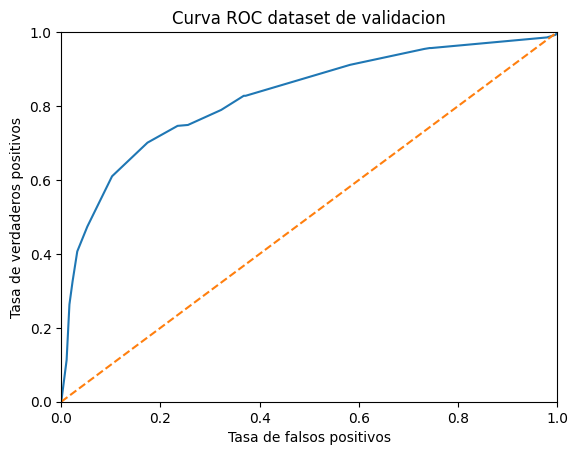

In [28]:
# Curva ROC dataset de validacion
plt.figure()

plt.plot(fpr_val, tpr_val)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

plt.title('Curva ROC dataset de validacion')
plt.show()

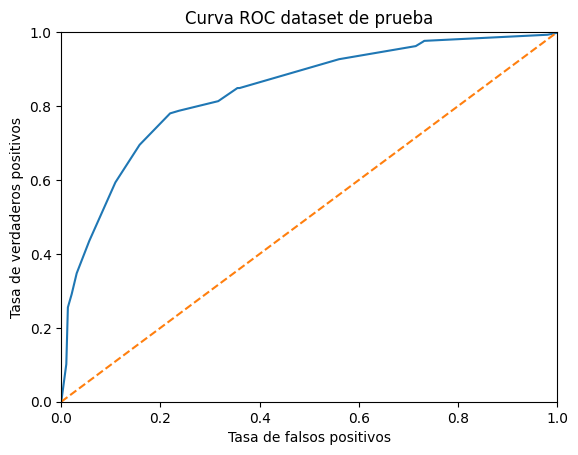

In [29]:
# Curva ROC dataset de prueba
plt.figure()

plt.plot(fpr_test, tpr_test)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

plt.title('Curva ROC dataset de prueba')
plt.show()

### Área Bajo la Curva ROC.

In [30]:
auc_roc_valid = roc_auc_score(target_val, probabilities_one_valid)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print(f'Área Bajo la Curva ROC para el dataset de validacion = {auc_roc_valid}')
print()
print(f'Área Bajo la Curva ROC para el dataset de validacion = {auc_roc_test}')

Área Bajo la Curva ROC para el dataset de validacion = 0.8241029464247908

Área Bajo la Curva ROC para el dataset de validacion = 0.8383867684249502


Con los resultados anteriores podemos deducir que la relación TVP-TFP es alta, por lo tanto pudimos construir un modelo de buena calidad que se encuentra lejos de predecir aleatoriamente.

